In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

Number of reviews: 568,454

Number of users: 256,059

Number of products: 74,258

Timespan: Oct 1999 — Oct 2012

Number of Attributes/Columns in data: 10

##### Number of Attributes/Columns in data:10 Attribute Information:
1. Id
2. ProductId - unique identier for the product
3. UserId - unqiue identier for the user
4. ProleName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

In [32]:
dataset = pd.read_csv('archive/Reviews.csv', nrows=10000)
print(len(dataset))
dataset.head()

10000


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [33]:
# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
#We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. 

dataset

filtered_data = dataset[dataset['Score'] != 3]
filtered_data

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

Number of data points in our data (9138, 10)


C:\Users\HarisPC\AppData\Local\Temp\ipykernel_9944\1057872763.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Score'] = positiveNegative


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Data Analysis

### Checking eduplication

In [34]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [35]:
print(sorted_data.shape)
len(sorted_data)-len(sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False))

(9138, 10)


420

In [36]:
sorted_data[sorted_data['UserId']=='AR5J8UI46CURR']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data

In [37]:
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep ='first', inplace=False)
final.shape

(8718, 10)

Observation:
It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [38]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [39]:
final.shape

(8718, 10)

1    7285
0    1433
Name: Score, dtype: int64


<AxesSubplot:>

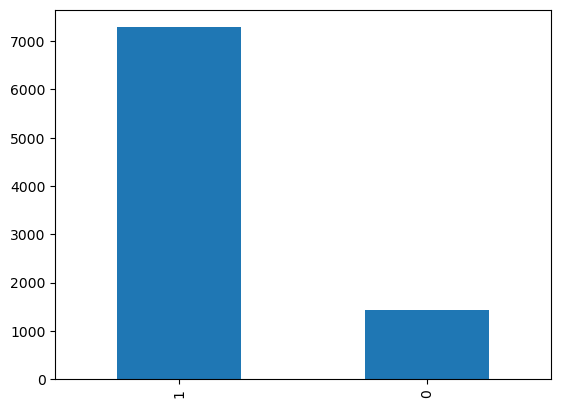

In [40]:
print(final['Score'].value_counts())
final['Score'].value_counts().plot(kind='bar')

[3] Preprocessing

[3.1]. Preprocessing Review Text

Text Preprocessing: Stemming, stop-word removal and Lemmatization
Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1.Begin by removing the html tags

2.Remove any punctuations or limited set of special characters like , or . or # etc.

3.Check if the word is made up of english letters and is not alpha-numeric

4.Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5.Convert the word to lowercase

6.Remove Stopwords

7.Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

In [41]:
final.shape#reduing dataset

(8718, 10)

In [42]:
#1.Begin by removing the html tags
#Display
import re
i =0 
for sent in final["Text"].values:
    if(len(re.findall("<.*?>", sent))):
        print(i)
        print(sent)
        break
    i+=1;

1
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In the below code  there are functions to remove stopwords and punctuation and html tags and also a function which will perform stemming.

In [43]:
from sklearn.metrics import roc_auc_score

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final['Text'], final['Score'], random_state = 0, test_size=0.20)
print('X_train first entry: \n\n', X_train[0])
print('\n\nX_train shape: ', X_train.shape)

X_train first entry: 

 I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


X_train shape:  (6974,)


In [51]:
vect = CountVectorizer(min_df = 5, ngram_range = (1,2)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
len(vect.get_feature_names())

C:\Users\HarisPC\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


19268

In [52]:
from sklearn.linear_model import LogisticRegression

In [53]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_vectorized, y_train)
predictions = model.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.7710337115950765


In [54]:
print(model.predict(vect.transform(['The candy is not good, I would never buy them again','The candy is not bad, I will buy them again'])))

[0 1]


In [57]:
from sklearn.neighbors import KNeighborsClassifier
kclassifier = KNeighborsClassifier(n_neighbors=10)
kclassifier.fit(X_train_vectorized, y_train)

KNeighborsClassifier(n_neighbors=10)

In [58]:
predictionsKNN = kclassifier.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictionsKNN))

C:\Users\HarisPC\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


AUC:  0.52217810624525


In [60]:
from sklearn.ensemble import RandomForestClassifier
RFmodel = RandomForestClassifier(n_estimators=20)
RFmodel.fit(X_train_vectorized, y_train)

RandomForestClassifier(n_estimators=20)

In [61]:
predictionsKNN = RFmodel.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictionsKNN))

AUC:  0.6127381607568729


In [67]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=1000)
mlp.fit(X_train_vectorized,y_train)
predict_test = mlp.predict(vect.transform(X_test))
                            

In [68]:
print('AUC: ', roc_auc_score(y_test, predict_test))

AUC:  0.7771575333490579
